In [1]:
import torch 
from torch import nn
import torch.nn.functional as f
from torch.utils.data import TensorDataset, DataLoader,Dataset

import numpy as np
import pandas as pd
import os

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
data = pd.read_csv('captions.csv',usecols=['img_id','caption'])

memes/bad-luck-brian.jpg


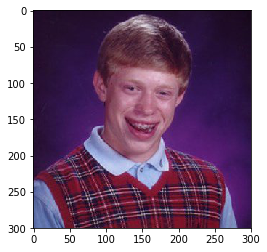

In [3]:
img_paths = ["memes" + str(img).lower() +'.jpg' for img in data['img_id']]
img_paths[:10]
img = mpimg.imread(img_paths[500])
print(img_paths[500])
plt.imshow(img)

In [4]:
tokens = ['<PERIOD>','<COMMA>','<QUOTATION_MARK>','<SEMICOLON>',
         '<EXCLAMATION_MARK>','<QUESTION_MARK>','<LEFT_PAREN>',
         '<RIGHT_PAREN>','<HYPHENS>','<NEW_LINE>','<COLON>','<START>',
         '<END>','<UNK>','<PAD>']

In [5]:
def prepare_vocab(data):
    text = [t.replace('-','\n') for t in data['caption']]
    all_text = ' '.join(text)
    all_text = all_text.replace('y u no','Why you no')
    all_text = all_text.lower()
    all_text = all_text.replace('.', ' <PERIOD> ')
    all_text = all_text.replace(',',' <COMMA> ')
    all_text = all_text.replace('"', ' <QUOTATION_MARK> ')
    all_text = all_text.replace(';', ' <SEMICOLON> ')
    all_text = all_text.replace('!', ' <EXCLAMATION_MARK> ')
    all_text = all_text.replace('?', ' <QUESTION_MARK> ')
    all_text = all_text.replace('(', ' <LEFT_PAREN> ')
    all_text = all_text.replace(')', ' <RIGHT_PAREN> ')
    all_text = all_text.replace('--', ' <HYPHENS> ')
    all_text = all_text.replace('?', ' <QUESTION_MARK> ')
    all_text = all_text.replace('\n', ' <NEW_LINE> ')
    all_text = all_text.replace(':', ' <COLON> ')
    
    
    words = all_text.split()
    word_counts = Counter(words)
    words = ["<UNK>" if word_counts[word] < 3 else word for word in words]
    print("Total words in text: {}".format(len(words)))
    print("Unique words: {}".format(len(set(words))))
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts,key=word_counts.get, reverse=True)
    sorted_vocab.append("<START>")
    sorted_vocab.append("<END>")
    sorted_vocab.append("<PAD>")
    print("Total words in vocab with start and end token: {}".format(len(sorted_vocab)))
    
    return (sorted_vocab, word_counts)


In [6]:
vocab, word_counts = prepare_vocab(data)

Total words in text: 2789711
Unique words: 33156
Total words in vocab with start and end token: 33159


In [7]:
def load_glove(glove_path):
    glove = {}
    with open(glove_path,'rb') as f:
        for l in f:
            line = l.decode().split()
            word = line[0]
            vect = np.array(line[1:]).astype(np.float)
            glove[word] = vect
    return glove

In [8]:
glove = load_glove('glove.6B/glove.6B.100d.txt')
len(glove)

400000

In [7]:
# prepare dictionaries
int_to_vocab = {ii:word for ii,word in enumerate(vocab)}
vocab_to_int = {word:ii for ii,word in int_to_vocab.items()}

In [8]:
def process_cap(caption):
    caption = caption.lower()
    caption = caption.replace('-','\n')
    all_text = caption.replace('y u no','why you no')
    all_text = all_text.replace('.', ' <PERIOD> ')
    all_text = all_text.replace(',',' <COMMA> ')
    all_text = all_text.replace('"', ' <QUOTATION_MARK> ')
    all_text = all_text.replace(';', ' <SEMICOLON> ')
    all_text = all_text.replace('!', ' <EXCLAMATION_MARK> ')
    all_text = all_text.replace('?', ' <QUESTION_MARK> ')
    all_text = all_text.replace('(', ' <LEFT_PAREN> ')
    all_text = all_text.replace(')', ' <RIGHT_PAREN> ')
    all_text = all_text.replace('--', ' <HYPHENS> ')
    all_text = all_text.replace('?', ' <QUESTION_MARK> ')
    all_text = all_text.replace('\n', ' <NEW_LINE> ')
    all_text = all_text.replace(':', ' <COLON> ') 
    
    all_text = " ".join(["<UNK>" if (word_counts[word] < 3 and word not in tokens) else word for word in all_text.split()])
       
    enc = [vocab_to_int[word] for word in all_text.split()]
    
    return enc

In [9]:
enc_captions = [process_cap(x) for x in data['caption']]

In [10]:
enc_captions[2]

[2731, 0, 57, 5, 23, 333, 4472, 92, 276, 4, 6]

<BarContainer object of 50 artists>

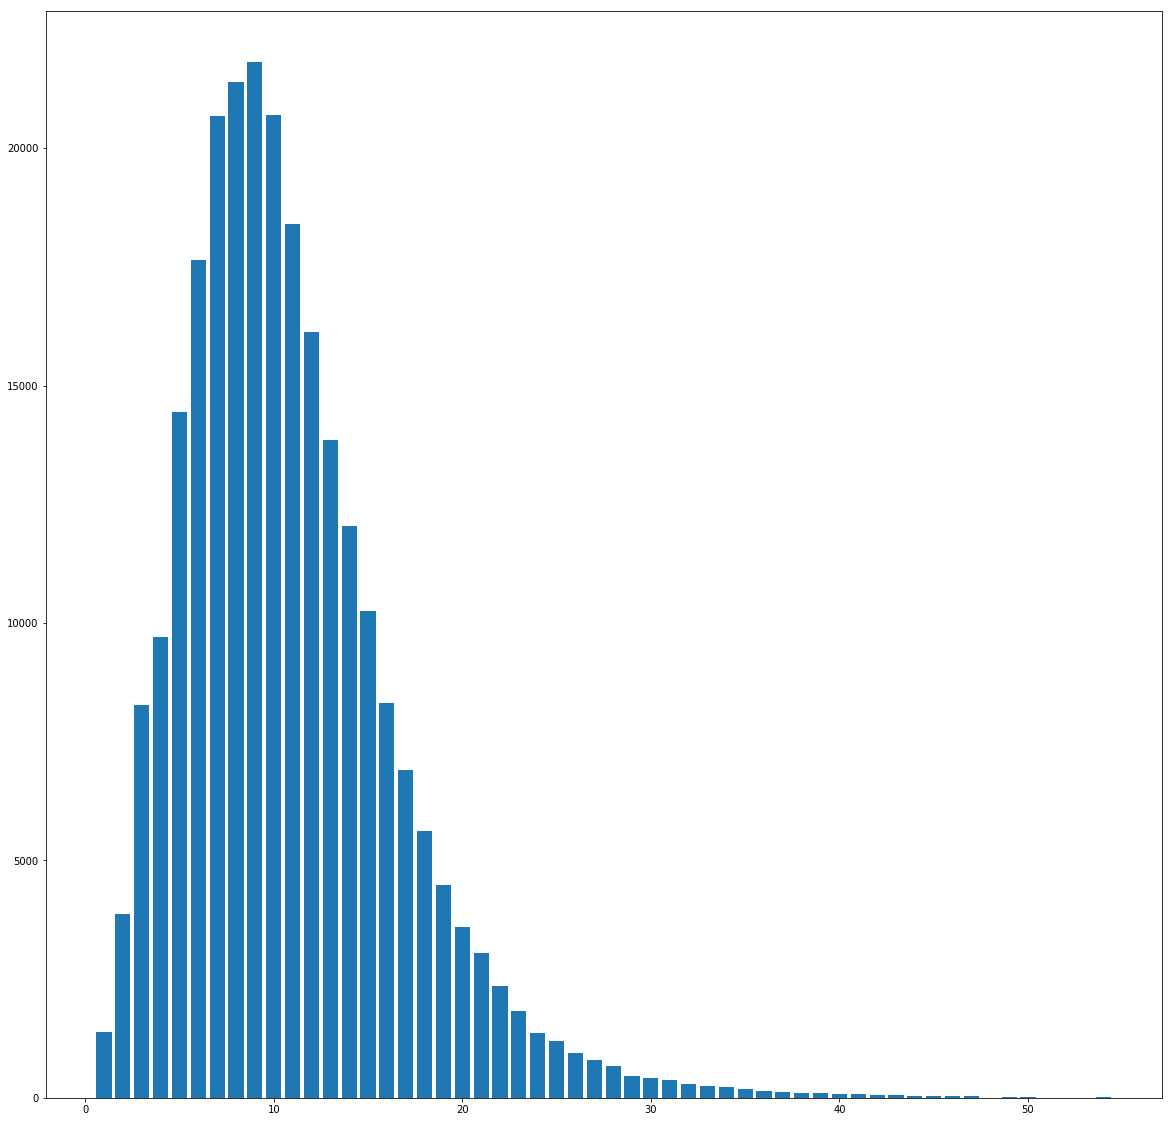

In [11]:
enc_caplens = [len(x) for x in enc_captions]
freq = Counter(enc_caplens)
freq_keys=sorted(freq,key = freq.get,reverse=True)
freq_values = [freq[x] for x in freq_keys]
plt.figure(figsize=(20,20))
plt.bar(freq_keys[:50],freq_values[:50])

In [12]:
max_len = 14
len(enc_captions[1])
vocab_to_int['<PAD>']

33158

In [38]:
def pad_and_encode(enc_captions,max_len = 14):
    enc_caplens = [len(x)+2 if (len(x)+2)<=max_len else max_len for x in enc_captions]
    enc_captions_ = []
    for i,c in enumerate(enc_captions):
        if len(c)>(max_len-2):
            e = [vocab_to_int['<START>']] + enc_captions[i][:(max_len-2)] + [vocab_to_int['<END>']]
            enc_captions_.append(np.array(e))
            assert len(e)==14
        else:
            e_ = [vocab_to_int['<START>']] + enc_captions[i] + [vocab_to_int['<END>']] + [vocab_to_int['<PAD>']]*(max_len-len(enc_captions[i])-2)
            enc_captions_.append(np.array(e_))
            assert len(e_)==14, len(e_)
    return np.array(enc_captions_),np.array(enc_caplens)
            

enc_captions_, enc_caplens = pad_and_encode(enc_captions,max_len=14)

In [40]:
enc_captions_.shape

(255080, 14)

In [41]:
data['enc_captions'] = [x for x in enc_captions_]

In [42]:
# data['encoded_caption'] = enc_captions_
data['caplens'] = enc_caplens
data['img_paths'] = img_paths
data['img_paths'] = data['img_paths'].apply(lambda x: x.replace('advicejew','advice-jew'))

In [43]:
data.head()

,img_id,caption,enc_captions,caplens,img_paths
0,/Y-U-No,meme generator users-y u no give me more upvotes?,"[33156, 127, 1337, 3909, 0, 57, 5, 23, 124, 15...",14,memes/y-u-no.jpg
1,/Y-U-No,steve jobs-y u no respawn?!,"[33156, 1012, 975, 0, 57, 5, 23, 7013, 6, 4, 3...",11,memes/y-u-no.jpg
2,/Y-U-No,commercial-y u no same volume as show!?,"[33156, 2731, 0, 57, 5, 23, 333, 4472, 92, 276...",13,memes/y-u-no.jpg
3,/Y-U-No,Victoria-y u no tell us your secret?!,"[33156, 6239, 0, 57, 5, 23, 110, 209, 19, 1068...",13,memes/y-u-no.jpg
4,/Y-U-No,KONY-Y u no take justin bieber,"[33156, 933, 0, 57, 5, 23, 125, 478, 600, 3315...",10,memes/y-u-no.jpg


In [44]:
data.to_csv('Encoded_captions.csv')

In [47]:
import pickle

In [48]:
pickle_out = open("dicts/vocab_to_int.pickle","wb")
pickle.dump(vocab_to_int, pickle_out)
pickle_out.close()

In [49]:
pickle_out = open("dicts/int_to_vocab.pickle","wb")
pickle.dump(int_to_vocab, pickle_out)
pickle_out.close()

In [10]:
pickle_out = open("dicts/glove.pickle","wb")
pickle.dump(glove, pickle_out)
pickle_out.close()

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data.sample(frac=1),test_size = 0.3, shuffle=True)

In [58]:
print("train_df {}".format(train_df['img_id'].describe()['unique']))
print("Test_df {}".format(test_df['img_id'].describe()['unique']))

train_df 1335
Test_df 1335


In [53]:
np.save('data/encoded_captions.npy',data['enc_captions'])
np.save('data/caplens.npy',data['caplens'])
np.save('data/img_paths.npy',data['img_paths'])

In [59]:
np.save('data/train_enc_captions.npy',train_df['enc_captions'])
np.save('data/train_caplens.npy',train_df['caplens'])
np.save('data/train_imgpaths.npy',train_df['img_paths'])

In [60]:
np.save('data/test_enc_captions.npy',test_df['enc_captions'])
np.save('data/test_caplens.npy',test_df['caplens'])
np.save('data/test_imgpaths.npy',test_df['img_paths'])